In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Prepare the Data

In [2]:
import tensorflow_datasets as tfds

In [3]:
train, test = tfds.load('fashion_mnist', split=['train', 'test'], shuffle_files=True, as_supervised=True)

In [4]:
def normalize_img(img, label):
    return tf.cast(img, tf.float32)/255., label
train = train.map(normalize_img)
train = train.batch(128).prefetch(tf.data.experimental.AUTOTUNE)


(28, 28, 1)
tf.Tensor(2, shape=(), dtype=int64)


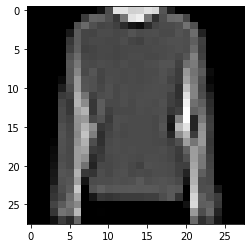

In [5]:
for example in train.take(1):
    plt.imshow(example[0][0], cmap='gray')
    print(example[0][0].shape)
    print(example[1][0])

# Simple Classification

In [6]:
# Lets use functional API, even though sequential is sufficient
inputs = keras.layers.Input(shape=(28,28,1))
z = keras.layers.Conv2D(16, 3, strides=1, padding='same', activation='relu')(inputs)
z = keras.layers.MaxPool2D(2)(z)
z = keras.layers.Conv2D(32, 3, strides=1, padding='same', activation='relu')(z)
z = keras.layers.MaxPool2D(2)(z)
z = keras.layers.Conv2D(32, 3, strides=1, padding='same', activation='relu')(z)
z = keras.layers.MaxPool2D(2)(z)
z = keras.layers.Flatten()(z)
z = keras.layers.Dense(10, activation='relu')(z)
output = keras.layers.Softmax()(z)

simple_conv_clf = keras.Model(inputs=[inputs], outputs=[output])


In [7]:
simple_conv_clf.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adam(1e-3), metrics=['accuracy'])

In [8]:
simple_conv_clf.fit(train, epochs=5)

Epoch 1/5
469/469 [==============================] - 44s 93ms/step - loss: 0.8543 - accuracy: 0.7443
Epoch 2/5
469/469 [==============================] - 37s 78ms/step - loss: 0.6093 - accuracy: 0.8178
Epoch 3/5
469/469 [==============================] - 37s 78ms/step - loss: 0.5602 - accuracy: 0.8291
Epoch 4/5
469/469 [==============================] - 37s 79ms/step - loss: 0.5328 - accuracy: 0.8361
Epoch 5/5
469/469 [==============================] - 37s 78ms/step - loss: 0.5132 - accuracy: 0.8408


In [9]:
inputs = keras.layers.Input(shape=(28,28,1))
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(200, activation='relu')(z)
z = keras.layers.Dense(100, activation='relu')(z)
z = keras.layers.Dense(10, activation='relu')(z)
outputs = keras.layers.Softmax()(z)

simple_fc_clf = keras.Model(inputs=[inputs], outputs=[outputs])
simple_fc_clf.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Adam(1e-3), metrics=['accuracy'])

In [10]:
simple_fc_clf.fit(train, epochs=5)

Epoch 1/5
469/469 [==============================] - 5s 12ms/step - loss: 0.7364 - accuracy: 0.7594
Epoch 2/5
469/469 [==============================] - 5s 11ms/step - loss: 0.4493 - accuracy: 0.8446
Epoch 3/5
469/469 [==============================] - 6s 12ms/step - loss: 0.3430 - accuracy: 0.8775
Epoch 4/5
469/469 [==============================] - 5s 11ms/step - loss: 0.3141 - accuracy: 0.8869
Epoch 5/5
469/469 [==============================] - 5s 11ms/step - loss: 0.2926 - accuracy: 0.8936


# Lets make some simple custom layers

### Lets use keras dataset instead of TF Dataset, because its a bit less abstract and easier to modify


In [11]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [12]:
print(x_train.shape, x_train.dtype)
print(y_train.shape)

(60000, 28, 28) uint8
(60000,)


In [13]:
x_train = tf.cast(x_train, tf.float32) / 255.
x_test = tf.cast(x_test, tf.float32) / 255.

#### convert labels to categorical (Because I had difficulty with on the fly later) 
TODO: Figure out how to convert y_true on the fly to categorical

In [14]:
y_train_cat = keras.utils.to_categorical(y_train, num_classes=10)
y_test_cat =  keras.utils.to_categorical(y_test, num_classes=10)

### Lets start with a simple custom loss

In [15]:
def my_crossentropy(y_true, y_pred):
    m = y_pred.shape[-1]
    
    # Note: I had issues trying to convert to categorical on the fly, 
    # so I changed the original labels instead in the dataset as above
    # y_true_cat = keras.utils.to_categorical(y_true, num_classes=m)
    # return -1/m * keras.backend.sum(y_true_cat * keras.backend.log(y_pred))
    
    return -1/m * keras.backend.sum(y_true * keras.backend.log(y_pred))
    

In [16]:
inputs = keras.layers.Input(shape=(28,28,1))
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(200, activation='relu')(z)
z = keras.layers.Dense(100, activation='relu')(z)
z = keras.layers.Dense(10, activation='relu')(z)
outputs = keras.layers.Softmax()(z)
simple_fc_clf_2 = keras.Model(inputs=[inputs], outputs=[outputs])
simple_fc_clf_2.compile(loss=my_crossentropy, optimizer=keras.optimizers.Adam(1e-3), metrics=['accuracy'])

### Lets also plot some validation accuracy (for ease, we just use test set as validation set)
simple_fc_clf_2.fit(x_train, y_train_cat, epochs=5, validation_data=(x_test, y_test_cat))

Epoch 1/5
1875/1875 [==============================] - 6s 3ms/step - loss: 3.4164 - accuracy: 0.6373 - val_loss: 3.2424 - val_accuracy: 0.6503
Epoch 2/5
1875/1875 [==============================] - 6s 3ms/step - loss: 3.0941 - accuracy: 0.6579 - val_loss: 3.0905 - val_accuracy: 0.6622
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 3.0009 - accuracy: 0.6640 - val_loss: 3.0607 - val_accuracy: 0.6646
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 2.9471 - accuracy: 0.6669 - val_loss: 3.1012 - val_accuracy: 0.6606
Epoch 5/5
1875/1875 [==============================] - 6s 3ms/step - loss: 2.8104 - accuracy: 0.6818 - val_loss: 2.5848 - val_accuracy: 0.7110


### Lets add a custom metric

In [17]:
def top_3_acc(y_true, y_pred):
    return tf.compat.v1.math.in_top_k(y_pred, tf.compat.v1.argmax(y_true, axis=-1), k=3)

def top_1_acc(y_true, y_pred):
    return tf.compat.v1.math.in_top_k(y_pred, tf.compat.v1.argmax(y_true, axis=-1), k=1)

# More General
def create_top_k_acc(k):
    def top_k_acc(y_true, y_pred):
        return tf.compat.v1.math.in_top_k(y_pred, tf.compat.v1.argmax(y_true, axis=-1), k=k)
    return top_k_acc


In [18]:
inputs = keras.layers.Input(shape=(28,28,1))
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(200, activation='relu')(z)
z = keras.layers.Dense(100, activation='relu')(z)
z = keras.layers.Dense(10, activation='relu')(z)
outputs = keras.layers.Softmax()(z)
simple_fc_clf_2 = keras.Model(inputs=[inputs], outputs=[outputs])
simple_fc_clf_2.compile(loss=my_crossentropy, optimizer=keras.optimizers.Adam(1e-3), 
                        metrics=['accuracy', top_1_acc, top_3_acc])
simple_fc_clf_2.fit(x_train, y_train_cat, epochs=5, validation_data=(x_test, y_test_cat))

Epoch 1/5
1875/1875 [==============================] - 6s 3ms/step - loss: 2.3342 - accuracy: 0.7765 - top_1_acc: 0.7860 - top_3_acc: 0.9736 - val_loss: 2.0023 - val_accuracy: 0.8282 - val_top_1_acc: 0.8310 - val_top_3_acc: 0.9833
Epoch 2/5
1875/1875 [==============================] - 6s 3ms/step - loss: 1.8396 - accuracy: 0.8428 - top_1_acc: 0.8447 - top_3_acc: 0.9851 - val_loss: 1.9857 - val_accuracy: 0.8346 - val_top_1_acc: 0.8375 - val_top_3_acc: 0.9776
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 1.7309 - accuracy: 0.8580 - top_1_acc: 0.8601 - top_3_acc: 0.9879 - val_loss: 1.8522 - val_accuracy: 0.8487 - val_top_1_acc: 0.8518 - val_top_3_acc: 0.9848
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 1.6605 - accuracy: 0.8665 - top_1_acc: 0.8684 - top_3_acc: 0.9901 - val_loss: 1.8008 - val_accuracy: 0.8569 - val_top_1_acc: 0.8601 - val_top_3_acc: 0.9868
Epoch 5/5
1875/1875 [==============================] - 6s 3ms/step - loss: 1

### Lets makes some custom layers

In [19]:
# Lets make a simple, custom flatten layer since it has no weights
def my_flatten_layer(x):
    # return keras.layers.Flatten()(x)
    shape = x.get_shape().as_list() # or list(x.shape)
    flat_dim = np.prod(shape[1:]) # product of all dimensions besides batch dimension
    return tf.reshape(x, [-1, flat_dim]) # -1 means infer from the rest --- so infer batch size
    
my_flatten_lambda_layer = keras.layers.Lambda(lambda x: keras.layers.Flatten()(x))

In [20]:
tf.random.set_seed(42)
inputs = keras.layers.Input(shape=(28,28,1))
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(200, activation='relu')(z)
z = keras.layers.Dense(100, activation='relu')(z)
z = keras.layers.Dense(10, activation='relu')(z)
outputs = keras.layers.Softmax()(z)
simple_fc_clf_2 = keras.Model(inputs=[inputs], outputs=[outputs])
simple_fc_clf_2.compile(loss=my_crossentropy, optimizer=keras.optimizers.Adam(1e-3), 
                        metrics=['accuracy', top_1_acc, top_3_acc])
simple_fc_clf_2.fit(x_train, y_train_cat, epochs=1, validation_data=(x_test, y_test_cat))

1875/1875 [==============================] - 6s 3ms/step - loss: 5.2510 - accuracy: 0.3457 - top_1_acc: 0.8218 - top_3_acc: 0.9954 - val_loss: 5.1049 - val_accuracy: 0.3553 - val_top_1_acc: 0.8693 - val_top_3_acc: 0.9986


In [21]:
tf.random.set_seed(42)
inputs = keras.layers.Input(shape=(28,28,1))
z = keras.layers.Lambda(lambda x: keras.layers.Flatten()(x))(inputs)
z = keras.layers.Dense(200, activation='relu')(z)
z = keras.layers.Dense(100, activation='relu')(z)
z = keras.layers.Dense(10, activation='relu')(z)
outputs = keras.layers.Softmax()(z)
simple_fc_clf_2 = keras.Model(inputs=[inputs], outputs=[outputs])
simple_fc_clf_2.compile(loss=my_crossentropy, optimizer=keras.optimizers.Adam(1e-3), 
                        metrics=['accuracy', top_1_acc, top_3_acc])
simple_fc_clf_2.fit(x_train, y_train_cat, epochs=1, validation_data=(x_test, y_test_cat))

1875/1875 [==============================] - 7s 4ms/step - loss: 5.2510 - accuracy: 0.3457 - top_1_acc: 0.8218 - top_3_acc: 0.9954 - val_loss: 5.1049 - val_accuracy: 0.3553 - val_top_1_acc: 0.8693 - val_top_3_acc: 0.9986


In [22]:
tf.random.set_seed(42)
inputs = keras.layers.Input(shape=(28,28,1))
z = my_flatten_layer(inputs)
z = keras.layers.Dense(200, activation='relu')(z)
z = keras.layers.Dense(100, activation='relu')(z)
z = keras.layers.Dense(10, activation='relu')(z)
outputs = keras.layers.Softmax()(z)
simple_fc_clf_2 = keras.Model(inputs=[inputs], outputs=[outputs])
simple_fc_clf_2.compile(loss=my_crossentropy, optimizer=keras.optimizers.Adam(1e-3), 
                        metrics=['accuracy', top_1_acc, top_3_acc])
simple_fc_clf_2.fit(x_train, y_train_cat, epochs=1, validation_data=(x_test, y_test_cat))

1875/1875 [==============================] - 6s 3ms/step - loss: 5.2510 - accuracy: 0.3457 - top_1_acc: 0.8218 - top_3_acc: 0.9954 - val_loss: 5.1049 - val_accuracy: 0.3553 - val_top_1_acc: 0.8693 - val_top_3_acc: 0.9986


#### The outputs of all three above are identical 

#### Lets make a custom softmax as well

In [23]:
def my_softmax(x):
    return tf.exp(x)/tf.reduce_sum(tf.exp(x), axis=-1, keepdims=True)
    

In [24]:
tf.random.set_seed(42)
inputs = keras.layers.Input(shape=(28,28,1))
z = my_flatten_layer(inputs)
z = keras.layers.Dense(200, activation='relu')(z)
z = keras.layers.Dense(100, activation='relu')(z)
z = keras.layers.Dense(10, activation='relu')(z)
outputs = my_softmax(z)
simple_fc_clf_2 = keras.Model(inputs=[inputs], outputs=[outputs])
simple_fc_clf_2.compile(loss=my_crossentropy, optimizer=keras.optimizers.Adam(1e-3), 
                        metrics=['accuracy', top_1_acc, top_3_acc])
simple_fc_clf_2.fit(x_train, y_train_cat, epochs=1, validation_data=(x_test, y_test_cat))

1875/1875 [==============================] - 6s 3ms/step - loss: 5.2524 - accuracy: 0.3456 - top_1_acc: 0.8208 - top_3_acc: 0.9953 - val_loss: 5.1196 - val_accuracy: 0.3544 - val_top_1_acc: 0.8540 - val_top_3_acc: 0.9990


#### The output is not "identical" but it is very close, so perhaps any difference is negligible and due to rounding or precision 

## Multiple Outputs, Losses, and Metrics

#### We can make this into an autoencoder and have a reconstruction loss, but have the encoder be a classifier

#### Lets make a simple autoencoder first for reference

In [25]:
inputs = keras.layers.Input(shape=(28,28,1))
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(200, activation='relu')(z)
z = keras.layers.Dense(100, activation='relu')(z)
encoder_out = keras.layers.Dense(10, activation='relu')(z)

decoder_in = encoder_out
z = keras.layers.Dense(100, activation='relu')(decoder_in)
z = keras.layers.Dense(200, activation='relu')(z)
z = keras.layers.Dense(28*28*1, activation='relu')(z)
decoder_out = keras.layers.Reshape((28,28))(z)


# ae_clf = keras.Model(inputs=[inputs], outputs=[decoder_out, clf_out])
ae_clf = keras.Model(inputs=[inputs], outputs=[decoder_out])


In [26]:
ae_clf.compile(loss='mse', optimizer=keras.optimizers.Adam(1e-3))
ae_clf.fit(x_train,x_train)

1875/1875 [==============================] - 10s 5ms/step - loss: 0.0345


In [27]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")
    
def show_reconstruction(model, n_images, multi_output=False):
    #reconstructions = model.predict(test.take(n_images))
    fig = plt.figure(figsize=(n_images*1.5, 3))
    for img_index, img in enumerate(x_test[:n_images]):
        reconstruction = model.predict(tf.reshape(img, (1,28,28,1)))
        plt.subplot(2, n_images, 1 + img_index)
        plot_image(img)
        plt.subplot(2, n_images, 1 + img_index + n_images)
        if multi_output:
            plot_image(reconstruction[0][0])
        else:
            plot_image(reconstruction[0])
        

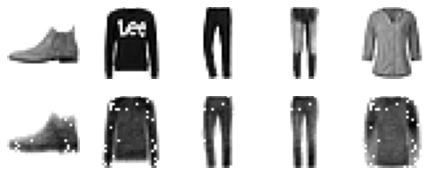

In [28]:
show_reconstruction(ae_clf, 5)

#### Now Lets Add a clf output and loss

In [29]:
inputs = keras.layers.Input(shape=(28,28,1))
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(200, activation='relu')(z)
z = keras.layers.Dense(100, activation='relu')(z)
encoder_out = keras.layers.Dense(10, activation='relu')(z)

clf_out = keras.layers.Softmax(name='clf_out')(encoder_out)

decoder_in = encoder_out
z = keras.layers.Dense(100, activation='relu')(decoder_in)
z = keras.layers.Dense(200, activation='relu')(z)
z = keras.layers.Dense(28*28*1, activation='relu')(z)
decoder_out = keras.layers.Reshape((28,28), name='decoder_out')(z)


ae_clf = keras.Model(inputs=[inputs], outputs=[decoder_out, clf_out])

In [30]:
losses = {'decoder_out':'mse', 'clf_out':"sparse_categorical_crossentropy"}
loss_weights = {'decoder_out':1.0, 'clf_out':1.0}
ae_clf.compile(loss= losses, loss_weights= loss_weights, 
               optimizer=keras.optimizers.Adam(1e-3), metrics={'decoder_out':'MAE', 'clf_out':'accuracy'})

#### Notice that we set a name for some of the layers above that we need a reference to. Lets print the model summary below to make sure those layers were indeed names as desired

In [31]:
ae_clf.summary()

Model: "functional_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
flatten_6 (Flatten)             (None, 784)          0           input_10[0][0]                   
__________________________________________________________________________________________________
dense_28 (Dense)                (None, 200)          157000      flatten_6[0][0]                  
__________________________________________________________________________________________________
dense_29 (Dense)                (None, 100)          20100       dense_28[0][0]                   
______________________________________________________________________________________

In [32]:
ae_clf.fit(x_train,y={'decoder_out':x_train, 'clf_out':y_train})

1875/1875 [==============================] - 12s 6ms/step - loss: 1.3314 - decoder_out_loss: 0.0627 - clf_out_loss: 1.2687 - decoder_out_MAE: 0.1627 - clf_out_accuracy: 0.5529


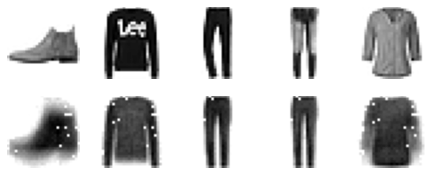

In [33]:
show_reconstruction(ae_clf, 5, multi_output=True)

In [34]:
clf_head_only = keras.Model(inputs=[inputs], outputs=[clf_out])
clf_head_only.summary()

Model: "functional_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 200)               157000    
_________________________________________________________________
dense_29 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_30 (Dense)             (None, 10)                1010      
_________________________________________________________________
clf_out (Softmax)            (None, 10)                0         
Total params: 178,110
Trainable params: 178,110
Non-trainable params: 0
_______________________________________________

In [35]:
for i in range(5):
    print("pred:", np.argmax(clf_head_only.predict(tf.reshape(x_test[i], (1,28,28,1)))), "label:", y_test[i])

pred: 9 label: 9
pred: 2 label: 2
pred: 1 label: 1
pred: 1 label: 1
pred: 6 label: 6


#### Lets do a quick time test to see if we have a performace boost by seperating out the classifier head

In [36]:
import time
from tqdm import tqdm

example = tf.reshape(x_test[1], (1,28,28,1))
start = time.time()
for i in tqdm(range(100)):
    clf_head_only.predict(example)
print("clf_head_only time:", time.time() - start)

start = time.time()
for i in tqdm(range(100)):
    ae_clf.predict(example)
print("full time:", time.time() - start)

start = time.time()
for i in tqdm(range(100)):
    clf_head_only.predict(example)
print("clf_head_only time:", time.time() - start)



  2%|▏         | 2/100 [00:00<00:06, 14.25it/s]

clf_head_only time: 5.901282072067261


  2%|▏         | 2/100 [00:00<00:06, 14.43it/s]

full time: 6.237814903259277


100%|██████████| 100/100 [00:06<00:00, 16.66it/s]

clf_head_only time: 6.005067825317383


#### Interesting -- we don't really see any speedup happening

#### Below, I'm just trying to figure out why top k accuracy where k = 1 is any different categorical accuracy. Only thing I see different so far is that if two categories have the same predicted output, then categorical accuracy will say its wrong, and top k will say its right. But I feel like that might not be the only case, since the descrepency is quite large... 

In [37]:
inputs = keras.layers.Input(shape=(28,28,1))
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(200, activation='relu')(z)
z = keras.layers.Dense(100, activation='relu')(z)
z = keras.layers.Dense(10, activation='relu')(z)
outputs = keras.layers.Softmax()(z)
simple_fc_clf_2 = keras.Model(inputs=[inputs], outputs=[outputs])
simple_fc_clf_2.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(1e-3), 
                        metrics=["accuracy", "categorical_accuracy", tf.keras.metrics.TopKCategoricalAccuracy(k=1), top_1_acc, top_3_acc])
simple_fc_clf_2.fit(x_train, y_train_cat, epochs=1)

1875/1875 [==============================] - 7s 4ms/step - loss: 1.4234 - accuracy: 0.4753 - categorical_accuracy: 0.4753 - top_k_categorical_accuracy: 0.7845 - top_1_acc: 0.7845 - top_3_acc: 0.9876


In [38]:
m = tf.keras.metrics.CategoricalAccuracy()
m.update_state([[0, 0, 1], [0, 1, 0]], [[0.1, 0.9, 0.9],
                 [0.05, 0.95, 0]])
m.result().numpy()

0.5

In [39]:
m = tf.keras.metrics.TopKCategoricalAccuracy(k=1)
m.update_state([[0, 0, 1], [0, 1, 0]], [[0.1, 0.9, 0.9],
                 [0.05, 0.95, 0]])
m.result().numpy()

1.0